In [3]:
%pip install imutils


  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25870 sha256=8cc70ba50ee205033440cfb1644fa23211756ae960885f3ab4854306b25d1bfd
  Stored in directory: c:\users\vietv\appdata\local\pip\cache\wheels\85\cf\3a\e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\vietv\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


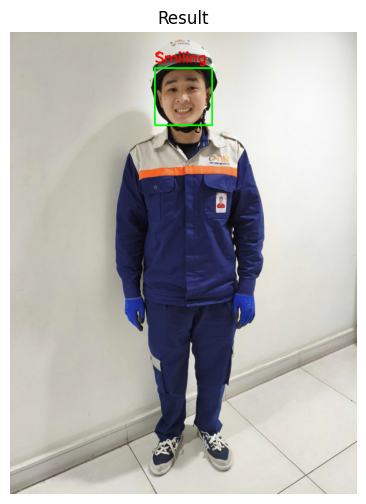

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import mediapipe as mp
import numpy as np
import argparse
import imutils
import cv2
import os

# Tạo thư mục output nếu chưa có
os.makedirs("output_imgs", exist_ok=True)

# Đối số dòng lệnh
args = {
    "cascade": "Smile_Detection/Smile_Detection/haarcascade_frontalface_default.xml",
    "model": "Smile_Detection/Smile_Detection/output/smile.h5",
    "image": "E:/TTS/DetectedClothesRight-tbao/DetectedClothesRight-tbao/test/z6759168215525_e33f3d963c9875b24aec7c05ed8a4d0b.jpg"
}



# Load model và face detector
model = load_model(args["model"])
detector = cv2.CascadeClassifier(args["cascade"])

# Mediapipe Face Mesh
mp_face = mp.solutions.face_mesh
face_mesh = mp_face.FaceMesh(static_image_mode=True, max_num_faces=1)

# Load ảnh đầu vào
image = cv2.imread(args["image"])
image = imutils.resize(image, width=600)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Phát hiện khuôn mặt
rects = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

if len(rects) > 0:
    (fX, fY, fW, fH) = rects[0]

    # Cắt roi từ ảnh màu
    roi_color = image[fY:fY + fH, fX:fX + fW]
    roi_rgb = cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB)
    roi_resized = cv2.resize(roi_rgb, (224, 224))
    
    # Xử lý ảnh
    array_img = img_to_array(roi_resized)
    array_img = preprocess_input(array_img)

    # Mediapipe: đặc trưng môi
    results = face_mesh.process(roi_rgb)
    if results.multi_face_landmarks:
        landmarks = results.multi_face_landmarks[0].landmark
        left = landmarks[61]
        right = landmarks[291]
        top = landmarks[13]
        bottom = landmarks[14]
        mouth_width = np.linalg.norm(np.array([left.x, left.y]) - np.array([right.x, right.y]))
        mouth_height = np.linalg.norm(np.array([top.y]) - np.array([bottom.y]))
    else:
        mouth_width, mouth_height = 0.0, 0.0

    # Kết hợp: flatten ảnh + đặc trưng môi
    combined = np.append(array_img.flatten(), [mouth_width, mouth_height])
    combined = np.expand_dims(combined, axis=0)

    # Dự đoán
    (notSmiling, smiling) = model.predict(combined, verbose=0)[0]
    label = "Smiling" if smiling > notSmiling else "Not Smiling"

    # Vẽ kết quả
    cv2.putText(image, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.rectangle(image, (fX, fY), (fX + fW, fY + fH), (0, 255, 0), 2)

# Lưu ảnh kết quả
basename = os.path.basename(args["image"])
output_path = os.path.join("output_imgs", f"result_{basename}")
cv2.imwrite(output_path, image)

import matplotlib.pyplot as plt

# Chuyển BGR → RGB để hiển thị đúng màu trong matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.title("Result")
plt.show()
